In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow_hub as hub

# from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Rescaling
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomFlip, RandomRotation, RandomTranslation, RandomCrop, RandomBrightness
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping
from sklearn.metrics import confusion_matrix

AUTOTUNE = tf.data.AUTOTUNE
np.set_printoptions(suppress=True)

#### Loading Dataset


In [3]:
df = pd.read_csv("./dataset/train/_classes.csv")
dict_disease = {}

for number, name in enumerate(df.columns):
    if name == 'filename':continue              # skip 1st column
    dict_disease[number-1] = name.strip()
dict_disease = {key: dict_disease[key] for key in dict_disease if key != 'Unlabeled'}
img_size = 224

In [4]:
def loadImage(path, label, image_size=None, return_label=False):
    labels = pd.read_csv(label)
    labels = labels.sort_values('filename')
    labels = labels.loc[:, labels.columns != 'filename']
    labels = np.array(labels.idxmax(axis=1).str.strip().astype(
            'category').cat.codes).reshape(-1, 1)
    
    if return_label:
        return labels
    images = tf.keras.utils.image_dataset_from_directory(path, shuffle=False, batch_size=None, label_mode=None, image_size=image_size)
    labels = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((images, labels))

def confusionMatrix(epoch, logs):
    test_loss, test_acc = model.evaluate(test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}\nTest Accuracy: {test_acc*100:.2f}%")
    
    yhat = model.predict(test, verbose=0)
    yhat = np.argmax(yhat, axis=1)
    cm = confusion_matrix(yhat, test_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm)
    for (x, y), value in np.ndenumerate(cm):
        plt.text(x, y, f"{value:.2f}", va="center", ha="center", color='white')
    ax.set_title(f"Confusion Matrix on epoch {epoch+1}\nVal accuracy: {logs.get('val_accuracy'):.2f}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticks_position('bottom')

    try:
        os.makedirs("./CM/")
    except FileExistsError:
        pass

    fig.savefig(f"./CM/Epoch {epoch+1}.jpg")
    fig.clf()

In [ ]:
with tf.device('/cpu:0'):
    path_train = "./dataset/train/"
    path_valid = "./dataset/valid/"
    path_test = "./dataset/test/"
    train_dataset = loadImage(path_train, path_train+"_classes.csv", image_size=(img_size,img_size))
    valid_dataset = loadImage(path_valid, path_valid+"_classes.csv", image_size=(img_size,img_size))
    test_dataset = loadImage(path_test, path_test+"_classes.csv", image_size=(img_size,img_size))
    test_labels = loadImage(path_test, path_test+"_classes.csv", return_label=True)

In [6]:
with tf.device('/cpu:0'):
    train = train_dataset.cache('train_dataset').shuffle(256, reshuffle_each_iteration=True).map(
        lambda image, label: (tf.cast(image, tf.float32), label)).batch(32).repeat(1).prefetch(AUTOTUNE)
    valid = valid_dataset.cache('valid-dataset').batch(32).prefetch(AUTOTUNE)
    test = test_dataset.cache('test-dataset').batch(32).prefetch(AUTOTUNE)

### Buat Model


#### Non Fine Tunable Model


In [7]:
# base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_size,img_size,3), include_top=False, include_preprocessing=False, pooling='max')
# base_model.trainable=False

# model = Sequential([
#     Input((img_size, img_size, 3)),
#     Rescaling(1/255),               # range [0,1]
#     # Rescaling(1/127.5, offset=-1),  # range [-1,1]
#     RandomFlip(),
#     RandomRotation(factor=0.3),
#     RandomZoom(height_factor=(-0.2, 0.2)),
#     RandomBrightness(factor=(-0.2,0.2), value_range=[0,1]),
#     base_model,
#     Dense(128, 'selu'),
#     Dense(len(dict_disease.keys()), activation='softmax')
# ])

# model.compile(
#     loss=SparseCategoricalCrossentropy(),
#     optimizer=RMSprop(learning_rate=0.0005, centered=True),
#     metrics=['accuracy']
# )

# bestCB = ModelCheckpoint(filepath='./checkpoint/best/', monitor='val_accuracy',
#                          mode='max', verbose=1, save_best_only=True)

# cmCB = LambdaCallback(on_epoch_end=confusionMatrix)

# esCB = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# # model.build([None, img_size, img_size, 3])
# model.summary()

#### Fine Tuning Model


In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_size,img_size,3), include_top=False, include_preprocessing=False, pooling='max')
base_model.trainable=True

input = Input((img_size, img_size, 3))
preprocess_layer = Rescaling(1/255)(input)
# model_layer = Rescaling(1/127.5, offset=-1)
preprocess_layer = RandomFlip()(preprocess_layer)
preprocess_layer = RandomRotation(factor=0.2)(preprocess_layer)
preprocess_layer = RandomZoom(height_factor=(-0.1, 0.1))(preprocess_layer)
preprocess_layer = RandomBrightness(factor=(-0.1,0.1), value_range=[0,1])(preprocess_layer)

data = base_model(preprocess_layer, training=False)
data = Dense(128, 'selu')(data)
output = Dense(len(dict_disease.keys()), activation='softmax')(data)

model = tf.keras.Model(input, output)

model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001, amsgrad=True),
    metrics=['accuracy']
)

bestCB = ModelCheckpoint(filepath='./checkpoint/best/', monitor='val_accuracy',
                         mode='max', verbose=1, save_best_only=True)

cmCB = LambdaCallback(on_epoch_end=confusionMatrix)

esCB = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# model.build([None, img_size, img_size, 3])
model.summary()

### Training Model


In [ ]:
# with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(
        train,
        validation_data=valid,
        epochs=1000,
        callbacks=[bestCB, cmCB, esCB]
    )

In [ ]:
model.save("./checkpoint/latest/")

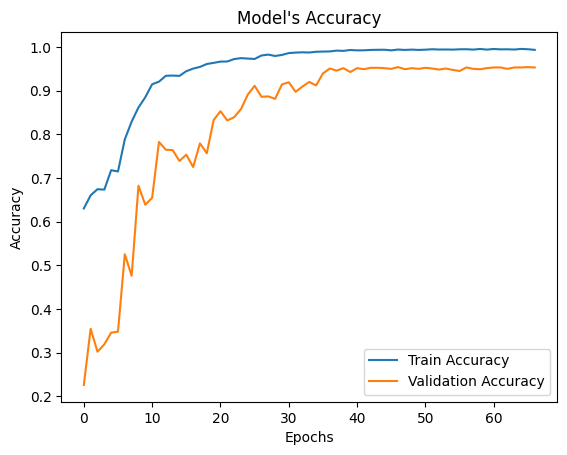

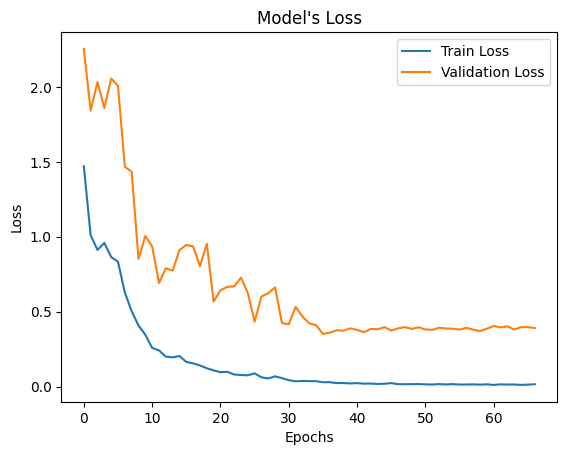

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model's Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model's Loss")
plt.legend()
plt.show()

#### Evaluasi Model


In [8]:
# Load iterasi terakhir
# model = tf.keras.models.load_model("./checkpoint/latest/")

# Load terbaik
model = tf.keras.models.load_model("./checkpoint/best/")

In [12]:
test_loss, test_acc = model.evaluate(test, verbose=0)
print(f"Loss: {test_loss:.4f}\nAccuracy: {test_acc*100:.2f}%")

Loss: 1.2083
Accuracy: 83.32%


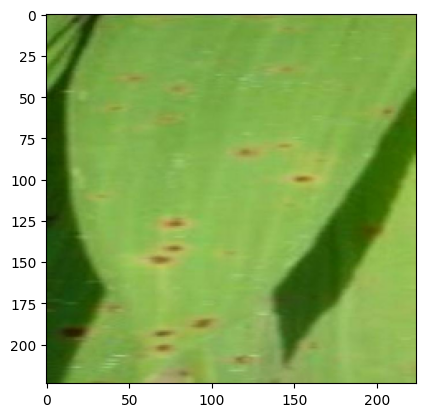

1/1 [==============================] - 1s 657ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


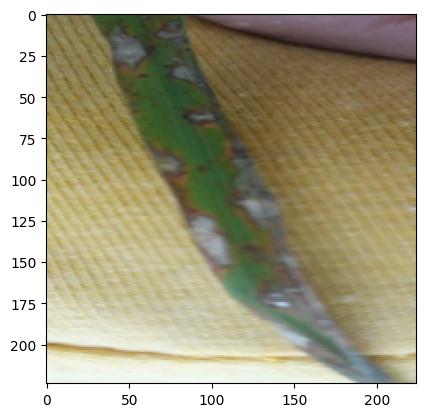

1/1 [==============================] - 0s 29ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 99.99%.
Prediksi 2 adalah: Brownspot (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.00%.


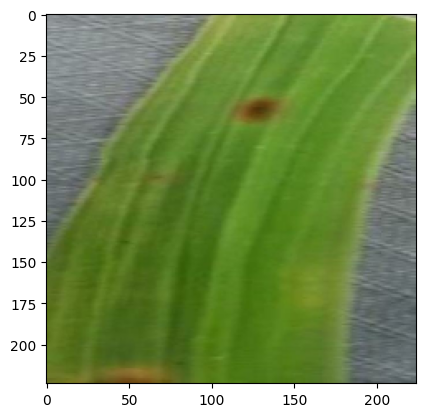

1/1 [==============================] - 0s 26ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Blast (salah) dengan probabilitas 0.00%.


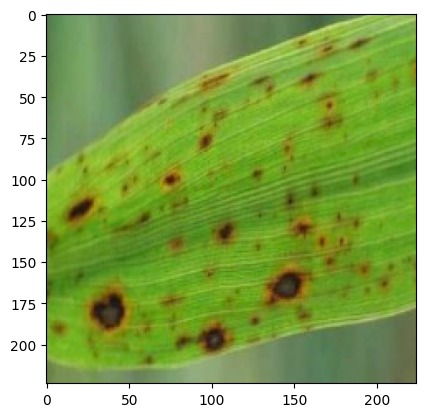

1/1 [==============================] - 0s 33ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


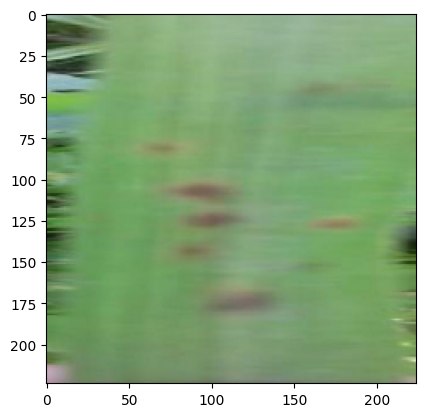

1/1 [==============================] - 0s 30ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


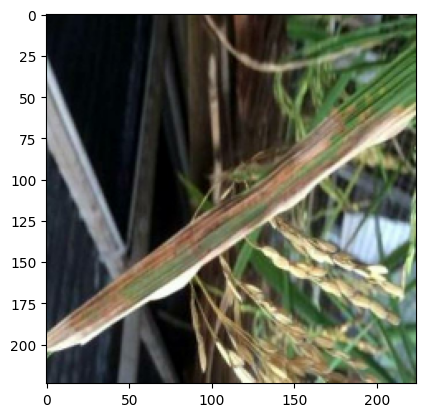

1/1 [==============================] - 0s 31ms/step
Label asli: BacterialBlight.
Prediksi 1 adalah: BacterialBlight (benar) dengan probabilitas 99.99%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.01%.
Prediksi 3 adalah: Brownspot (salah) dengan probabilitas 0.00%.


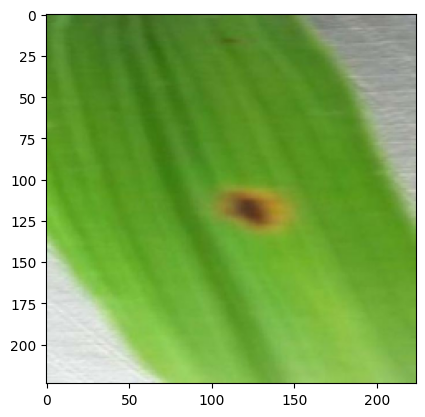

1/1 [==============================] - 0s 34ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Blast (salah) dengan probabilitas 0.00%.


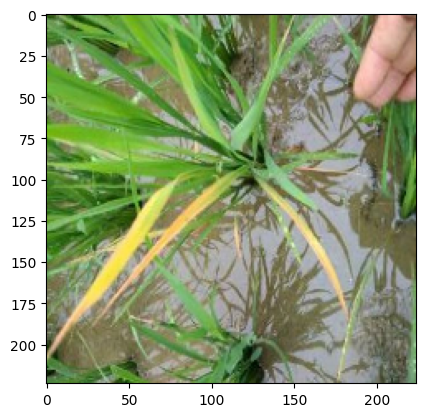

1/1 [==============================] - 0s 29ms/step
Label asli: Tungro.
Prediksi 1 adalah: Tungro (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Brownspot (salah) dengan probabilitas 0.00%.


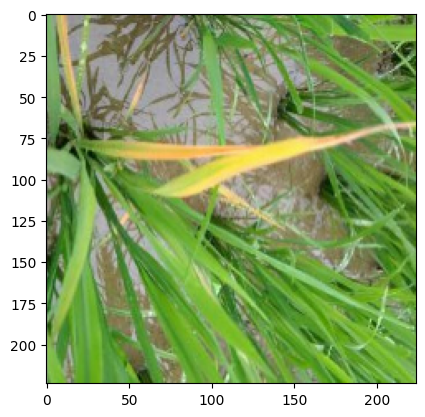

1/1 [==============================] - 0s 34ms/step
Label asli: Tungro.
Prediksi 1 adalah: Tungro (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Brownspot (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Blast (salah) dengan probabilitas 0.00%.


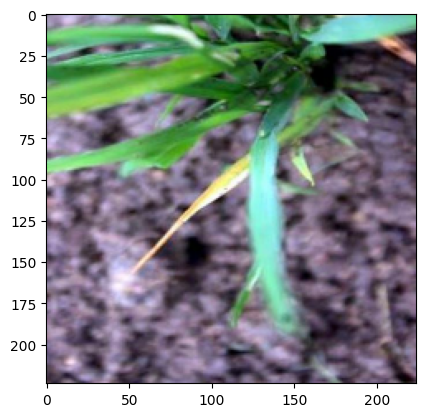

1/1 [==============================] - 0s 28ms/step
Label asli: Tungro.
Prediksi 1 adalah: Tungro (benar) dengan probabilitas 99.99%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Brownspot (salah) dengan probabilitas 0.00%.


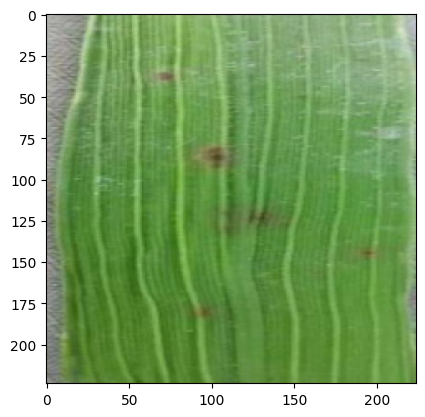

1/1 [==============================] - 0s 34ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


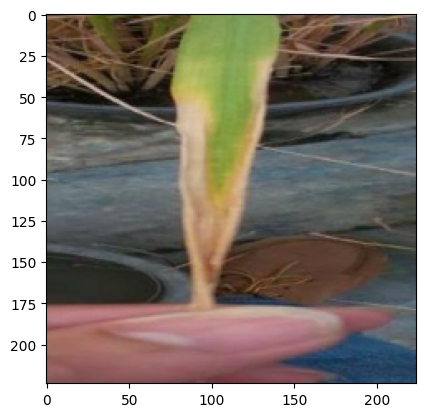

1/1 [==============================] - 0s 29ms/step
Label asli: BacterialBlight.
Prediksi 1 adalah: BacterialBlight (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


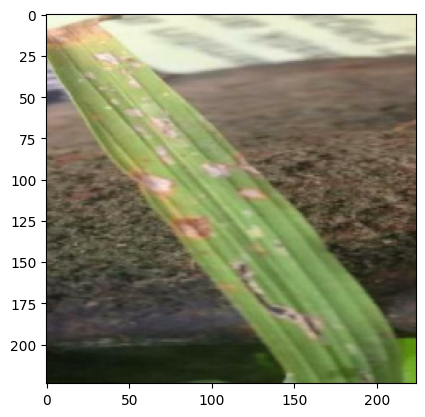

1/1 [==============================] - 0s 29ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Brownspot (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.00%.


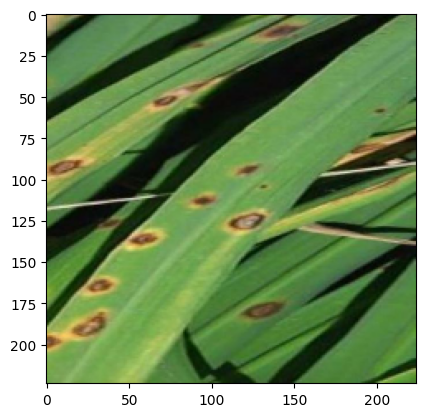

1/1 [==============================] - 0s 41ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


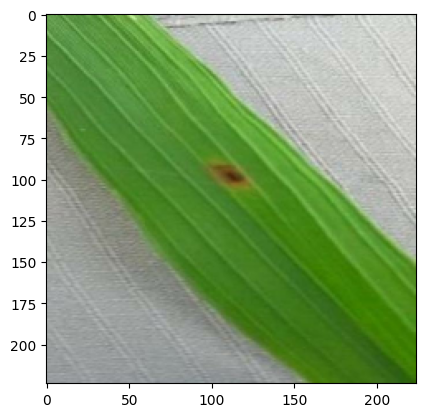

1/1 [==============================] - 0s 40ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Blast (salah) dengan probabilitas 0.00%.


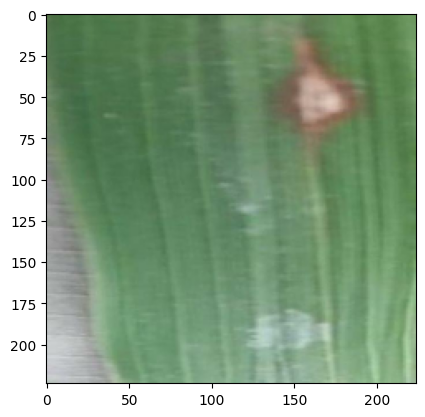

1/1 [==============================] - 0s 29ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Brownspot (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.


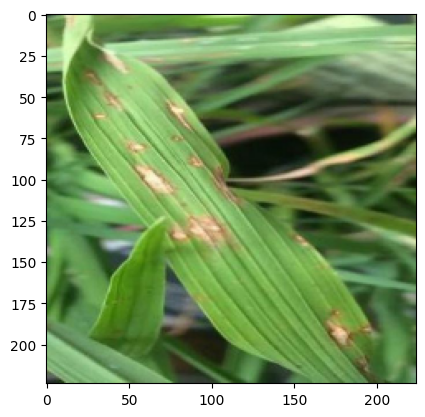

1/1 [==============================] - 0s 37ms/step
Label asli: Blast.
Prediksi 1 adalah: Blast (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Brownspot (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.00%.


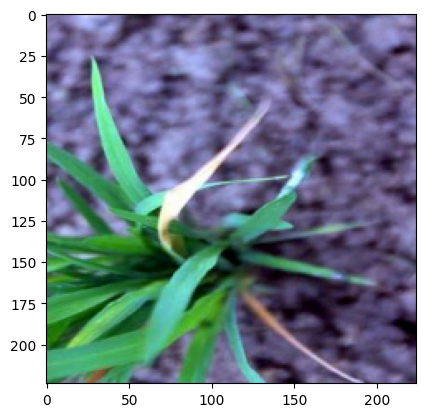

1/1 [==============================] - 0s 39ms/step
Label asli: Tungro.
Prediksi 1 adalah: Tungro (benar) dengan probabilitas 99.98%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.01%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.01%.


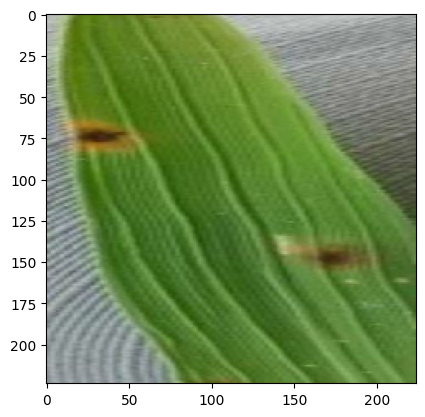

1/1 [==============================] - 0s 25ms/step
Label asli: Brownspot.
Prediksi 1 adalah: Brownspot (benar) dengan probabilitas 99.99%.
Prediksi 2 adalah: Blast (salah) dengan probabilitas 0.01%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.00%.


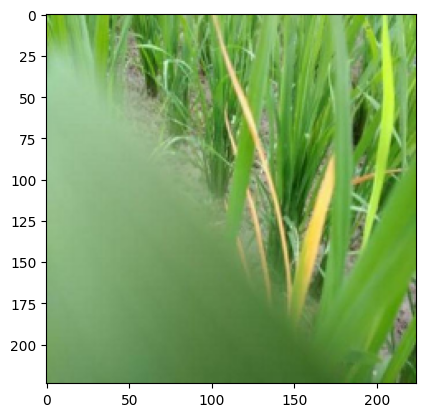

1/1 [==============================] - 0s 25ms/step
Label asli: Tungro.
Prediksi 1 adalah: Tungro (benar) dengan probabilitas 100.00%.
Prediksi 2 adalah: Leaf_Scald (salah) dengan probabilitas 0.00%.
Prediksi 3 adalah: BacterialBlight (salah) dengan probabilitas 0.00%.


In [15]:
topK = 3 # Ambil 3 kategori tertinggi untuk display ke user
for image, label in test_dataset.shuffle(128).take(20):
    image = tf.cast(image, tf.uint8)
    plt.imshow(image)
    plt.show()
    
    # image           = tf.cast(image, tf.float32) / 255
    image           = tf.expand_dims(image, axis=0)
    yhat            = model.predict(image)
    yhat_topk       = np.argpartition(-yhat, topK-1)[0][:3]
    true_label      = dict_disease[label.numpy()[0]]
    prob_res        = []
    disease_types   = []

    for disease in yhat_topk:
        disease_types.append(dict_disease[disease])
        prob_res.append(yhat[0][disease])
    
    print(f"Label asli: {true_label}.")
    for index_disease, disease in enumerate(disease_types):
        res = "benar" if true_label == disease else "salah"
        print(f"Prediksi {index_disease+1} adalah: {disease} ({res}) dengan probabilitas {prob_res[index_disease] * 100:.2f}%.")